Alternative Model

A Text Classification Assignment for Collecting and Analyzing Big Data (B-KUL-S0K17A)
FAO. Prof. Neal Caren
Predicting Movie Genre Based on Plot Summary
MSc Statistics and Data Science, Faculty of Science, KU Leuven 
Academic Year 2020/2021

Authors
Fazekas, Balazs r0827454
Vandermeersch, Lili r0691855

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import spacy
import re

We import the training set, the test set and our stopwords list. Next, we use the n-grams method to create bigrams and trigrams from the expressions in our dataset. Bigrams are two-word expressions which relate to a single piece of meaning. Example: "fast food", "United States" Trigrams are three-word expressions which relate to a single piece of meaning. Example: "against all odds", "based on results"

By creating n-grams, we can possibly improve our prediction score, as n-grams will try to predict how a certain number of expressions should end. Example: "United States" would have a large probability to end with "of America".


In [2]:
train = pd.read_csv("C:/Users/Balazs/Documents/train.csv")
testv2 = pd.read_csv("C:/Users/Balazs/Documents/test.csv")
stop_word = pd.read_csv("C:/Users/Balazs/Documents/stopwords_bn.txt", header=None)
stop_word_list = stop_word[0].tolist()

bigram = gensim.models.Phrases(train, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[train], threshold=100) 

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [3]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

We create a function to preprocess and later process the words in our dataset. We get rid of undesired characters such as: 

-roman numerals

-signs such as ", @ \ ' ? . $ % _ 

-single characters

-new line characters


In the processing part, we convert the Plots into a list of lowercase tokens, build n-grams and implement lemmatization
With tokenization we create a vocabulary. 
With lemmatization we turn words with different endings (but still the same stem), into just the stem. Example: "uses, used, user" turned into "use". 


In [4]:
def preprocessing(sentence):
    data = re.sub(r'[^a-zA-Z ]+', '', sentence) 

    # Delete roman numerals
    data = re.sub(r'(?=\b[MCDXLVI]{1,6}\b)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})', '', sentence)

    # Group multiple patterns
    data = re.sub(r'[,@\'?\.$%_]', '', sentence)

    # Delete new line characters
    data = re.sub(r'\s+', ' ', sentence)

    # Delete Single Characters
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Adding spaces between higher case words
    p = re.compile(r'(\S)([A-Z])')
    sentence_processed = re.sub(p, r"\1 \2", sentence)
    
    return sentence_processed

def process_words(texts, stop_words=stop_word_list, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a Plot into a list of lowercase tokens, build n-grams and lemmatize"""
    
    # Delete stopwords, short tokens, and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # implement n-grams: (bi-grams, tri-grams)
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []

    # lemmatization and filter for undesired speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # delete stopwords when done with lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out


In [5]:
train.Plot = train.Plot.apply(lambda x: preprocessing(x))
testv2.Plot = testv2.Plot.apply(lambda x:preprocessing(x))

We split our training set into a training and test set.

In [6]:
df_Plot = train[['Plot']]
train_list = df_Plot['Plot'].values.tolist()
df_Plot_testv2 = testv2[['Plot']]
testv2_list = df_Plot_testv2['Plot'].values.tolist()

In [7]:
train_processed = process_words(texts = train_list)


In [8]:
testv2_processed = process_words(texts = testv2_list)

In [9]:
train_processed = [" ".join(l) for l in train_processed]
testv2_processed = [" ".join(l) for l in testv2_processed]
train.Plot = train_processed
testv2.Plot = testv2_processed

In [10]:
train_split, test_split = train_test_split(train, train_size=0.75, random_state=770775)

We create a pipeline where we use CountVectorizer, TfidfTransformer and MultinomialNB. We also run Gridsearch on the training set to autotune our hyperparameters.

CountVectorizer: Creates tokens from the words in our "Plots".

TfidfTransformer:"Tf" is short for term frequency. "idf" is short for inverse document frequency. TfidfTransformer assigns weights to tokens. It assigns more weight to more important and less frequently occuring tokens. This will possibly greatly increase our prediction scoring. 

MultinomialNB: We use the Naive Bayes classifier for Multinomial models. This model is supposedly ideal for text classification. 

Gridsearch creates combinations throughout our dataset, and finds the optimal hyperparameters after having considered each combination.

In [11]:


# pipeline 
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_word_list, ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# tune the hyperparameters
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2,2)], # unigrams (two word expressions) or bigrams (three word expressions)
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 5e-3, 1e-3, 5e-4, 1e-4),
    
   
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=2, verbose = 1)
gs_clf = gs_clf.fit(train_split.Plot, train_split.Genre)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  5.7min finished
C:\Users\Balazs\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [12]:
# predict
gs_predict = gs_clf.predict(test_split.Plot)
gs_accuracy = np.mean(gs_predict == test_split.Genre)

# check best score
#  best mean score
gs_clf.best_score_
# the parameters pertaining to a score
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

best_ngram_range = gs_clf.best_params_['vect__ngram_range']
best_tfidf = gs_clf.best_params_['tfidf__use_idf']
best_clf_alpha = gs_clf.best_params_['clf__alpha']

# retrain the model based optimal parameter
text_clf_opt = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_word_list, ngram_range=best_ngram_range)),
    ('tfidf', TfidfTransformer(use_idf = best_tfidf)),
    ('clf', MultinomialNB(alpha=best_clf_alpha))
])
text_clf_opt.fit(train_split.Plot, train_split.Genre)
predicted = text_clf_opt.predict(test_split.Plot)
accuracy = np.mean(predicted == test_split.Genre)
print(accuracy)

tag_name = list(test_split.Genre.unique())
performance = classification_report(y_true=test_split.Genre, y_pred=predicted)

clf__alpha: 0.001
tfidf__use_idf: False
vect__ngram_range: (1, 2)


C:\Users\Balazs\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0.5989061075660893


Our optimal hyperparameters are shown above: 

-clf__alpha: 0.001
                                             
-tfidf__use_idf: False
                                            
-vect__ngram_range: (1, 2)

The accuracy of our model on the training split was : 59.89%.

In [13]:
train.Genre.unique()

array(['thriller', 'romance', 'comedy', 'western', 'horror', 'drama',
       'adventure', 'action', 'crime'], dtype=object)

Text(33.0, 0.5, 'actual')

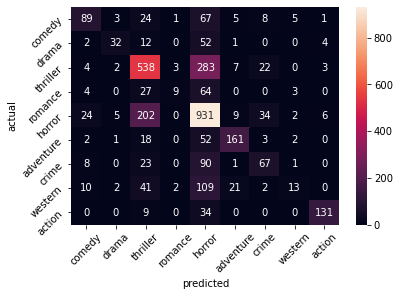

In [14]:
# check for similar genre labels

labels = train_split.Genre.unique()
test_label = test_split.Genre
confusion = confusion_matrix(test_label, predicted)
sns.heatmap(confusion, annot=True, fmt='g')
plt.xticks(np.arange(9)+.5, labels=labels, rotation = 45)
plt.yticks(np.arange(9)+.5, labels=labels, rotation = 45)
plt.xlabel('predicted')
plt.ylabel('actual')

The above is a confusion matrix of our predicted movie genres plotted against the actual movie genres. This will be further discussed in our report.

In [15]:
testv2_predicted = text_clf_opt.predict(testv2.Plot)


The above line is to fit our model on the test set.

In [16]:
testv2["Genre"] = testv2_predicted
testv2.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot,Id,Genre
0,2008,"War, Inc.",American,Joshua Seftel,"John Cusack, Hilary Duff, Marisa Tomei, Joan C...","https://en.wikipedia.org/wiki/War,_Inc.",film open bar nunavut hitman brand hauser john...,0,comedy
1,1972,Children Shouldn't Play with Dead Things,American,Bob Clark,"Alan Ormsby, Valerie Mamches",https://en.wikipedia.org/wiki/Children_Shouldn...,story focus theatre troupe lead alan alan orms...,1,horror
2,1941,Dr. Kildare's Wedding Day,American,Harold S. Bucquet,"Lew Ayres, Laraine Day, Red Skelton",https://en.wikipedia.org/wiki/Dr._Kildare%27s_...,jame kildare finally marry nurse mary lamont b...,2,drama
3,2003,Devil's Pond,American,Joel Viertel,"Tara Reid, Kip Pardue",https://en.wikipedia.org/wiki/Devil%27s_Pond,newlywed mitch kip pardue julianne tara reid e...,3,horror
4,1999,Sirf Tum,Bollywood,Agathiyan,"Sanjay Kapoor, Jackie Shroff, Sushmita Sen, Pr...",https://en.wikipedia.org/wiki/Sirf_Tum_(1999_f...,strange kind story pen pal eventually fall lov...,4,romance


In [17]:
testv2['Predicted'] = text_clf_opt.predict(testv2.Plot) 
testv2[['Id','Predicted']].to_csv('C:/Users/Balazs/Documents/Balazs_Lili_alternative.csv', index=False)